Importing libraries that will be useful in the project.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.constants as scicon
from numba import jit

In [3]:
# Defining constants useful in the calculations

epsilon_r = 78                                      # Relative permittivity of the solution
a = (23e-6)**2 # micrometers to meters              # Distance between the grid points (As per the redefined distance given 
                                                    # the update on the 'Mattelab' page)
alpha = scicon.elementary_charge**2/(4*scicon.pi*scicon.epsilon_0*epsilon_r*a)  # Calculating alpha, which
                                                                                # will be defined later

In the first exercise (1a) we will implement a function to generate a grid of size $N\times N$ with $2M$ randomly placed monomers, one of a negative sign for each one of a positive sign. The function assumes $N^2 \geq 2M$, as $N^2$ is the number of grid locations, and therefore the maximum number of monomers that can be placed in the grid. As this assumption is reasonable - we do want the monomers to have room for moving around - the function have no exception handling for this.

In [4]:
@jit(nopython=True)
def generate_grid_of_monomers(N, M):    # Declaring the function for generating a grid of size N, 
                                        # with M positive and M negative monomers randomly placed on the grid
    
    grid = np.zeros((N,N))              # Generating a grid of zeroes, in which the monomers can be placed
    
    w_i = [1,-1]                        # A list of the possible signs of the charge
    
    for m in range(0,2*M):              # Iterating over the monomers that are to be placed, 
                                        # both the positively and negatively charged ones

        pos = 1                         # Initializing the variable pos, which is meant to take in the value of a point
                                        # in the grid so the code can check whether the point is a monomer or solution
                                        
        while pos != 0:                 # Ensures the code runs until there is selected an empty position at random
            a = random.randint(0,N-1)   # Selects a random x coordinate in the N times N grid
            b = random.randint(0,N-1)   # Selects a random y coordinate in the N times N grid
            pos = grid[b][a]            # Saves the value of the random grid point to pos
            if pos == 0:                # Checks whether the grid point is occupied by a monomer
                
                grid[b][a] = w_i[m//(M+1)] * ((m % M)+1)    # Saves the sign of the charge to the grid point, as well as 
                                                            # a unique number from 1 to M (There are 2 points with the same
                                                            # absolute value, but with differing signs). The charge sign is
                                                            # determined by whether the monomer is among the 
                                                            # first M monomers (m < M => m//M = 0) or among 
                                                            # the second set of M monomers (2M > m > M => m//M = 1)
    return grid


In [5]:
# Test code for the generate_grid_of_monomers function
GRID = generate_grid_of_monomers(5,5)

Code to visualize the formed grid, as per problem 1b):

In [38]:

def visualize_grid(grid):                   # Declearing a function to take a grid as a input, and then visualize the grid
    plt.figure(1,figsize=(8,8))
    plt.pcolormesh(grid[::-1],cmap="bwr")   # Visualizes the grid by pcolormesh, but rotates the grid to make the visualization line up with the grid. The colors ranges from red (positive values) to blue (negative values), and white represents values of zero.
    plt.show()


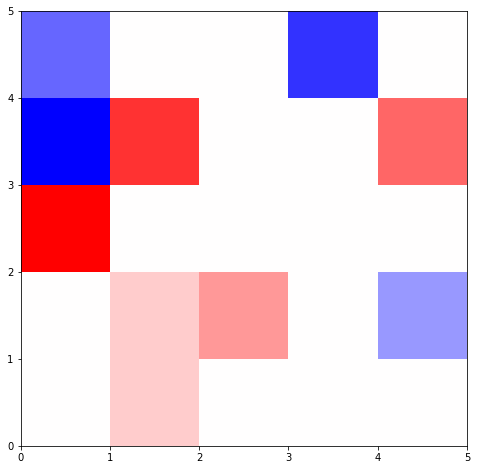

In [39]:
visualize_grid(GRID)  # Testing the code, by passing a N times N grid (5*5 in this instance) generated from the function generate_grid_of_monomers

Function to get coordinates of nearest neighboors, as per problem 1c):

In [8]:
@jit(nopython=True)
def get_neighbours_coordinates(N,coord):    # Takes in the size of a grid, and the coordinates of the point 
                                            # you want to find the neighbours of
    N_indices = np.append(np.append(np.array([N-1]), np.arange(0,N,1)), np.array([0]))  # Creates an array of the 
                                                                                        # form [N,0,1,...,N-2,N-1,0]

    i = coord[0] + 1 # Shifts the index to match the integer in the N_indices, as will be useful to get nearest neighboor
    j = coord[1] + 1 # Shifts the index to match the integer in the N_indices, as will be useful to get nearest neighboor

    return np.array([[N_indices[i-1],N_indices[j]],     # Gets indices of the nearest neighboors,
                     [N_indices[i+1],N_indices[j]],     # and returns them as arrays in an array
                     [N_indices[i],N_indices[j-1]],
                     [N_indices[i],N_indices[j+1]]])



In [9]:
# Testcode for the function
get_neighbours_coordinates(5,np.array([0,1]))

array([[4, 1],
       [1, 1],
       [0, 0],
       [0, 2]])

Following is the function used to calculate the energy of a given system, as required by problem 1d), by the use of the provided equation 4:
$$
E = V_{kl} = \{ \begin{array}{ll}
w_{k}w_{l}\alpha & r_k, r_l \in NN \\
0 & r_k, r_l \notin NN \\
\end{array}
$$

where 

$$
\alpha = \frac{e^2}{4\pi \varepsilon_0 \varepsilon_r a}
$$

Then all that's left to do is sum up the energy for all the monomers - while making sure no energy is doubly counted. Each energy calculated from the equation, is necessarily from the interaction of exactly two monomers. We want to count the energy of all the monomer interactions, that is, the interaction of the same two $r_k$ and $r_l$ should never be calculated more than once. If we however calculate all the interaction energies of one $r_l$ interacting with $r_k$, their interaction enegy is going to be calculated again when all the interaction energies of $r_k$ are calculated. This interaction energy is therefore counted exactly twice, and each doubly counted interaction energy, as well as the total energy, can be corrected by dividing by the integer 2 (The number of times each interaction energy is counted.)

In [10]:
@jit(nopython=True)
def get_sign(grid,monomer):                 # Gets the sign of the monomer in question

    if grid[monomer[0]][monomer[1]] == 0:   # If the coordinates point to solution instead 
        return 0                            # of a monomer, return a charge of zero
    else:
        return grid[monomer[0]][monomer[1]]/np.abs(grid[monomer[0]][monomer[1]]) # Takes in the monomers number and divides
                                                        # by the absolute, so as to preserve the sign while normalizing to one


@jit(nopython=True)
def calculate_energy(grid):
    monomers = np.argwhere(grid!=0)                         # Get all the monomer positions.
    total_energy = 0                                        # Variable to store the energy of all the monomers.

    for monomer in monomers:                                # We want to calculate energies for each and  
                                                            # every monomer, so we iterate over them.

        NN = get_neighbours_coordinates(len(grid),monomer)  # The monomers energies depend on its 
                                                            # neighbours, so we find their possible positions.

        if len(NN)>0:                                       # If the monomer have no neighbours it does not provide 
                                                            # any energy to the calculations, so we can ignore monomers
                                                            # with no neigbours.

            monomer_sign = get_sign(grid,monomer)           # As the number each monomer is assigned is just for 
                                                            # identification, we need to find the sign of the monomer.

            monomer_energy = 0                              # Variable to store the energy of all interactions 
                                                            # of each individual monomer
            for neighbour in NN:
                neighbour_sign = get_sign(grid,neighbour)
                interaction_energy = monomer_sign*neighbour_sign    # As per the provided equation 4, divided by alpha
                monomer_energy += interaction_energy        # Stores the interaction energies to the monomer in question
            total_energy += monomer_energy                  # Stores the monomer energies to the total energy

    return total_energy*alpha/2                             # Scales the energy by alpha, and divides by two to account
                                                            # for the double counting. This value is then returned

Here we are implementing the Monte Carlo algorithm described in Algorithm 2 (What this algorithm does should be further explained)

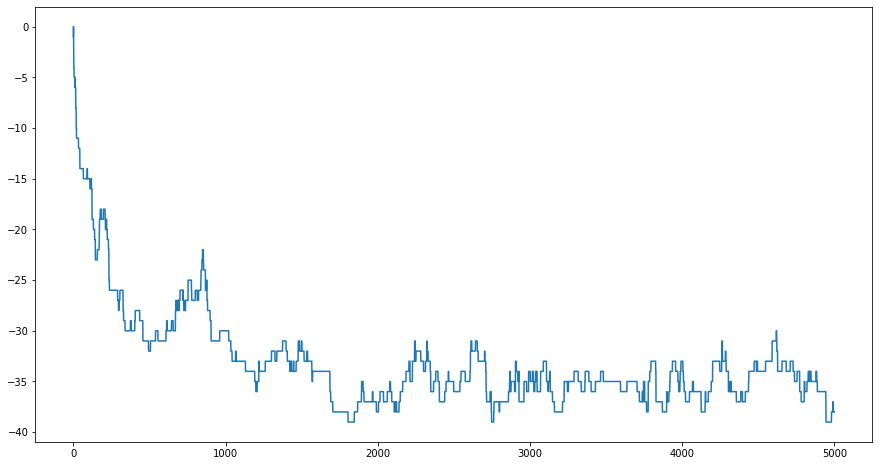

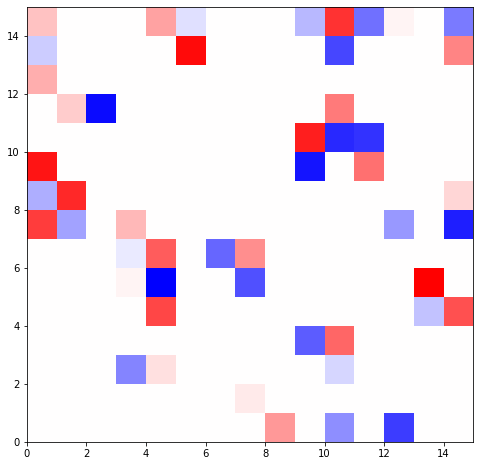

In [40]:
@jit(nopython=True)
def MonteCarlo2(N_s,T,grid):
    energies = np.zeros(N_s)                                 # Makes an array of length N_s to save the energies to.

    E_0 = calculate_energy(grid)
    energies[0] = E_0                                       # Saves the initial energy of the grid to the array.
    
    for i in range(1,N_s):
        
        E = calculate_energy(grid)                          # Calculates the energy of the grid in its current configuration.

        monomers = np.argwhere(grid!=0)                         # Fetches all of the monomers on the grid.
        monomer = monomers[random.randint(0,len(monomers)-1)]   # Fetches a random monomer which is to be moved.

        random_direction = random.randint(0,3)
        NNs = get_neighbours_coordinates(len(grid),monomer)
        desired_move = NNs[random_direction]                # Selects the random move out of the four possible directions.
        
        if grid[desired_move[0]][desired_move[1]] == 0:
            
            new_grid = grid.copy()
            new_grid[desired_move[0]][desired_move[1]] = new_grid[monomer[0]][monomer[1]]   # Copies the monomer over 
                                                                                            # to it's new placement.
            new_grid[monomer[0]][monomer[1]] = 0            # Removes the monomer from it's previous placement.
            
            E_new = calculate_energy(new_grid)
            d_E = E_new-E                                   # Calculate the change in energy by moving the random monomer.
            
            p = random.random()
            arnulf_bjorn_kristoffsen = np.exp(-d_E/(scicon.Boltzmann*T))        # Don't ask friends for variable names.
            
            
            if d_E < 0:
                grid = new_grid.copy() 
                E = E_new
            elif p < arnulf_bjorn_kristoffsen:
                grid = new_grid.copy()
                E = E_new
            
        energies[i] = E
    return energies, grid 

def simulate(N_s,N,M,T):

    e,g = MonteCarlo2(N_s,T,generate_grid_of_monomers(N,M))
    plt.figure(1,figsize=(15,8))
    plt.plot(np.linspace(0,N_s,N_s),e/alpha)
    plt.show()

    
    visualize_grid(g)
simulate(5000,15,25,200)